In [1]:
from keras.layers import Concatenate, Add,Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.optimizers import Adam, Nadam, SGD
from keras.callbacks import Callback
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.transform import rotate
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
%matplotlib inline
import itertools

Using TensorFlow backend.


In [2]:
images = pd.read_json("data/processed/train.json")

In [3]:
images['inc_angle'] = images['inc_angle'].apply(pd.to_numeric, errors='coerce')
images = images.dropna()

In [4]:
images.tail()

,band_1,band_2,id,inc_angle,is_iceberg
1504,"[-20.528059, -22.144562, -26.714188, -24.64341...","[-25.471151, -27.77906, -28.993053, -28.165241...",b2bc5d27,45.2814,1
1505,"[-15.371544, -14.431547, -15.970677, -18.76996...","[-22.540173, -23.125895, -21.643795, -24.43109...",71a0d13b,35.7829,0
1506,"[-23.945009, -23.316914, -25.883354, -22.36160...","[-26.738250999999998, -25.616005, -23.945156, ...",95ed1e8c,34.4721,1
1507,"[-26.656988, -26.972933, -27.300798, -26.05789...","[-23.135164, -24.474159, -23.559067, -25.23004...",bffad1b6,37.9814,0
1508,"[-16.241388, -17.401228, -18.385656, -19.23677...","[-26.05958, -24.065521, -23.421896, -25.257374...",ce151e35,35.2987,1


In [5]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [6]:
X_raw = color_composite(images)
Y_raw = np.array(images['is_iceberg']).reshape(X_raw.shape[0],1)
Inc_ang_raw = np.array(images['inc_angle']).reshape(X_raw.shape[0],1)

In [7]:
X_raw.shape
Y_raw.shape
Inc_ang_raw.shape

(1471, 1)

[0]


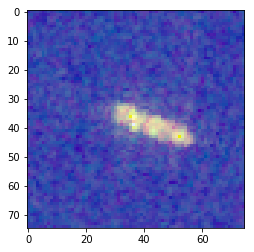

In [8]:
a = 100
pic = X_raw[a]
plt.imshow(pic)
print (Y_raw[a])

In [9]:
#X_raw, Y_raw = shuffle(X_raw, Y_raw, random_state=55)
X_train, X_dev, Y_train, Y_dev, Inc_ang_train, Inc_ang_dev= train_test_split(X_raw, Y_raw, Inc_ang_raw, test_size=0.15, random_state=75)

In [10]:
def data_augment(X,Y,Ang):
    X_aug = []
    Y_aug = []
    X_inc = []
    for i in range(X.shape[0]):
        pic = X[i]
        label = Y[i]
        inc_angle = Ang[i]
        X_aug.append(pic)
        Y_aug.append(label)
        X_inc.append(inc_angle/90)
        X_aug.append(pic[::-1])
        Y_aug.append(label)
        X_inc.append(inc_angle/90)
        X_aug.append(rotate(pic,180))
        Y_aug.append(label)
        X_inc.append(inc_angle/90)
        X_aug.append(rotate(pic[::-1],180))
        Y_aug.append(label)
        X_inc.append(inc_angle/90)
        
        X_aug.append(rotate(pic[::-1],90))
        Y_aug.append(label)
        X_inc.append(inc_angle/90)
        X_aug.append(rotate(pic,90))
        Y_aug.append(label)
        X_inc.append(inc_angle/90)
        X_aug.append(rotate(pic[::-1],270))
        Y_aug.append(label)
        X_inc.append(inc_angle/90)
        X_aug.append(rotate(pic,270))
        Y_aug.append(label)
        X_inc.append(inc_angle/90)
        
    return np.array(X_aug), np.array(Y_aug), np.array(X_inc)

In [11]:
X_train, Y_train, Inc_ang_train = data_augment(X_train,Y_train, Inc_ang_train)  

In [12]:
print (X_dev.shape, X_train.shape, Inc_ang_train.shape)

(221, 75, 75, 3) (5000, 75, 75, 3) (5000, 1)


In [ ]:
def matthews_correlation(y_true, y_pred):
    """Matthews correlation metric.
    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

### Simple model

In [13]:
def icebergModel():
    Input1 = Input(shape = (75, 75, 3))
    
    X = ZeroPadding2D((1, 1))(Input1)
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv0', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    
    
    X = ZeroPadding2D((1, 1))(X)
    X = Conv2D(256, (3, 3), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    
    X = Conv2D(512, (1, 1), strides = (1, 1), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    X = AveragePooling2D((2, 2), name='ave_pool0')(X)
        
    X = Flatten()(X)
    
    
    X = BatchNormalization(name = 'bn3')(X)
    X = Dense(10, activation='relu', name='fc_0', kernel_initializer = glorot_uniform(seed=0))(X)

    
    
    
    Input2 = Input(shape=(1,))
    X_1 = Dense(1, activation='relu', name='fc_1', kernel_initializer = glorot_uniform(seed=0))(Input2)
    X = Concatenate()([X, X_1])
    
    
    
    X = Dense(1, activation='sigmoid', name='output')(X)

    model = Model(inputs = [Input1,Input2], outputs = X, name='icebergModel')
    return model

In [14]:
icebergModel = icebergModel()

In [15]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()
optimizer = Adam(lr=0.00075, decay=1e-05) 

In [18]:
icebergModel.compile(optimizer = optimizer, loss="binary_crossentropy", metrics = ["accuracy",matthews_correlation])

In [19]:
#icebergModel = load_model('icebergModel.h5')
icebergModel.fit(x = [X_train, Inc_ang_train],y = Y_train, epochs = 50, batch_size = 64, callbacks=[history], verbose=1)

Epoch 1/50
5000/5000 [==============================] - 789s - loss: 0.8214 - acc: 0.7196 - matthews_correlation: 0.4819   
Epoch 2/50
5000/5000 [==============================] - 790s - loss: 0.5102 - acc: 0.7608 - matthews_correlation: 0.5439   
Epoch 3/50
5000/5000 [==============================] - 789s - loss: 0.4459 - acc: 0.7722 - matthews_correlation: 0.5740   
Epoch 4/50
5000/5000 [==============================] - 787s - loss: 0.4201 - acc: 0.7930 - matthews_correlation: 0.6083   
Epoch 5/50
5000/5000 [==============================] - 789s - loss: 0.3839 - acc: 0.8286 - matthews_correlation: 0.6682   
Epoch 6/50
5000/5000 [==============================] - 787s - loss: 0.3947 - acc: 0.8376 - matthews_correlation: 0.6847   
Epoch 7/50
5000/5000 [==============================] - 786s - loss: 0.3248 - acc: 0.8656 - matthews_correlation: 0.7380   
Epoch 8/50
5000/5000 [==============================] - 792s - loss: 0.4804 - acc: 0.8222 - matthews_correlation: 0.6622   
Epoch 9/

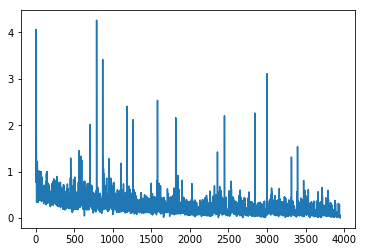

In [20]:
_ = plt.plot(history.losses)

In [21]:
preds = icebergModel.evaluate([X_dev,Inc_ang_dev], Y_dev)
print ("Loss:",preds[0])
print ("Dev Accuracy:",preds[1])
#Loss: 0.629512086983
#Dev Accuracy: 0.877828054838

221/221 [==============================] - 13s    
Loss: 0.50036084598
Dev Accuracy: 0.864253397171


In [27]:
preds = icebergModel.evaluate([X_train,Inc_ang_train], Y_train)
print ("Loss:",preds[0])
print ("Train Accuracy:",preds[1])
#Loss: 0.069182878628
#Train Accuracy: 0.9774

5000/5000 [==============================] - 378s   
Loss: 0.0520890808661
Train Accuracy: 0.9836


In [23]:
predictions = icebergModel.predict([X_dev,Inc_ang_dev])

#### ROC Curve

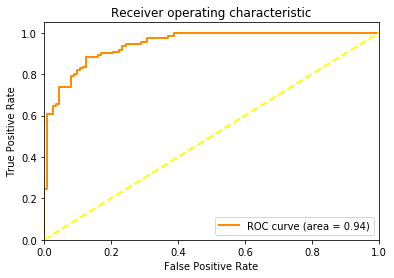

In [24]:
a,b, _ = roc_curve(Y_dev.ravel(), predictions.ravel())
c = auc(a,b)
plt.figure()

plt.figure()


lw = 2
plt.plot(a, b, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % c)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--', color = 'yellow')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

[[92 19]
 [11 99]]


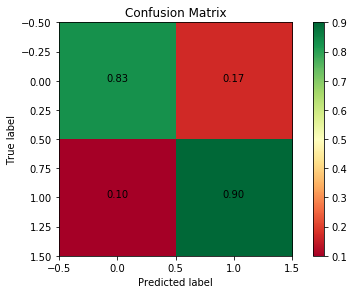

In [25]:
cm_raw = confusion_matrix(Y_dev, predictions>0.5)
cm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdYlGn)
plt.title('Confusion Matrix')
plt.colorbar()
#tick_marks = np.arange(len(2))
#plt.xticks(tick_marks, 'classes', rotation=45)
#plt.yticks(tick_marks, 'classes')
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
     horizontalalignment="center",
     color="black") #if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm_raw)

In [26]:
predictions

array([[  7.36654571e-10],
       [  1.07096836e-01],
       [  9.99989867e-01],
       [  7.80686969e-04],
       [  3.03387105e-01],
       [  9.99435604e-01],
       [  3.37874721e-04],
       [  9.99995589e-01],
       [  9.93990779e-01],
       [  2.95989912e-06],
       [  9.85592425e-01],
       [  9.99673247e-01],
       [  4.83798087e-01],
       [  5.81930298e-03],
       [  9.97178435e-01],
       [  9.99996543e-01],
       [  9.99637008e-01],
       [  5.77795319e-02],
       [  9.99932885e-01],
       [  9.99734461e-01],
       [  2.53682304e-03],
       [  9.99866605e-01],
       [  9.99999285e-01],
       [  9.65917051e-01],
       [  9.99941111e-01],
       [  5.87454975e-01],
       [  2.34161433e-07],
       [  9.91262555e-01],
       [  3.74854564e-10],
       [  9.99773443e-01],
       [  4.34801579e-01],
       [  8.12545940e-13],
       [  9.99934435e-01],
       [  5.08334097e-07],
       [  9.99940753e-01],
       [  8.67085278e-01],
       [  9.99980450e-01],
 

In [163]:
#weights = icebergModel.layers[-4].get_weights()

In [75]:
icebergModel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D) (None, 77, 77, 3)     0           input_5[0][0]                    
____________________________________________________________________________________________________
conv0 (Conv2D)                   (None, 75, 75, 128)   3584        zero_padding2d_5[0][0]           
____________________________________________________________________________________________________
bn0 (BatchNormalization)         (None, 75, 75, 128)   512         conv0[0][0]                      
___________________________________________________________________________________________

In [120]:
icebergModel.save('icebergModel_50its.h5')